# KAGGLE DATA


In [5]:
import os
from google.colab import files

# 1. Uploader kaggle.json
print("Uploader le fichier kaggle.json ici :")
files.upload()

# 2. Création du dossier .kaggle caché pour l'authentification
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# 3. Changer les permissions (sécurité requise par Kaggle)
!chmod 600 ~/.kaggle/kaggle.json

print("Installation Kaggle terminée !")

Uploader le fichier kaggle.json ici :


Saving kaggle.json to kaggle.json
Installation Kaggle terminée !


In [6]:
# 1. Téléchargement du jeu de données (commande API directe)
print("Téléchargement en cours...")
!kaggle datasets download -d paultimothymooney/breast-histopathology-images

# 2. Décompression
print("Décompression des fichiers (cela peut prendre 1 à 2 minutes)...")
# Décompresser dans un dossier 'data' spécifique pour éviter d'encombrer le répertoire racine
!unzip -q breast-histopathology-images.zip -d data

print("C'est terminé ! Les données se trouvent dans le dossier 'data'")

Téléchargement en cours...
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/breast-histopathology-images
License(s): CC0-1.0
 99% 3.06G/3.10G [00:46<00:01, 25.0MB/s]
100% 3.10G/3.10G [00:46<00:00, 71.8MB/s]
Décompression des fichiers (cela peut prendre 1 à 2 minutes)...
C'est terminé ! Les données se trouvent dans le dossier 'data'


In [7]:
# Afficher les 20 premiers fichiers/dossiers jusqu'à 3 niveaux de profondeur
!find data -maxdepth 3 | head -n 20

data
data/10291
data/10291/0
data/10291/0/10291_idx5_x2051_y1051_class0.png
data/10291/0/10291_idx5_x2951_y1601_class0.png
data/10291/0/10291_idx5_x751_y1751_class0.png
data/10291/0/10291_idx5_x2801_y951_class0.png
data/10291/0/10291_idx5_x301_y1951_class0.png
data/10291/0/10291_idx5_x2551_y901_class0.png
data/10291/0/10291_idx5_x2901_y1451_class0.png
data/10291/0/10291_idx5_x2551_y1701_class0.png
data/10291/0/10291_idx5_x3501_y1401_class0.png
data/10291/0/10291_idx5_x2601_y751_class0.png
data/10291/0/10291_idx5_x3351_y901_class0.png
data/10291/0/10291_idx5_x2651_y1051_class0.png
data/10291/0/10291_idx5_x2901_y1051_class0.png
data/10291/0/10291_idx5_x1051_y651_class0.png
data/10291/0/10291_idx5_x3001_y551_class0.png
data/10291/0/10291_idx5_x701_y1501_class0.png
data/10291/0/10291_idx5_x2201_y1501_class0.png


## 1. Dataset Overview & Structure

We are using the **Breast Histopathology Images** dataset. It contains small image patches extracted from microscopic scans of breast tissue.

### A. Directory Structure
The dataset is organized hierarchically by **Patient ID** and then by **Class**:

* **Root:** `data/`
* **Level 1:** `Patient_ID` (e.g., `16532/`, `10253/`...) represents a specific patient.
* **Level 2:** `Class Label` (0 or 1).
    * `0`: **Benign** (Healthy tissue).
    * `1`: **Malignant** (Cancerous tissue - Invasive Ductal Carcinoma).

### B. Filename Convention
Each file follows a specific naming pattern:
> `16532_idx5_x1601_y1101_class0.png`

* `16532`: Patient ID.
* `x1601_y1101`: Coordinates of the patch on the original slide.
* `class0`: The ground truth label (0 or 1).


### 💡 Important Note: Where do these images come from?

You might notice that a single patient ID folder contains hundreds of images.
* **Context:** The original data comes from **Whole Slide Images (WSI)** (gigantic scans of breast tissue).
* **Patching:** Because these scans are too large, they are cut into small **50x50 pixel patches**.
* **Result:**
    * Each file represents a tiny region of the patient's tissue.
    * A single patient contributes hundreds of patches to the dataset.
    * Our goal is to classify each *patch* individually.

# DATA CLEANING

## INTO DATAFRAME

In [8]:
import pandas as pd
from glob import glob
import os

# 1. Récupérer tous les chemins d'images à l'aide de glob
# On recherche de manière récursive dans 'data'
print("Scan des fichiers en cours... Cela peut prendre un moment.")
image_paths = glob('data/**/*.png', recursive=True)

print(f"Nombre total d'images trouvées : {len(image_paths)}")

# 2. Extraire les informations des chemins
# Structure observée dans les images : data/16532/0/nomdufichier.png
data = []

for path in image_paths:
    # On divise le chemin pour extraire les dossiers
    # Exemple de chemin : 'data/16532/0/img.png'
    # normpath assure la cohérence des séparateurs (/ ou \)
    parts = os.path.normpath(path).split(os.sep)

    # Basé sur la structure du jeu de données :
    # parts[-1] = nomdufichier
    # parts[-2] = id_classe ('0' ou '1')
    # parts[-3] = id_patient ('16532')

    label = parts[-2]
    patient_id = parts[-3]

    # On ajoute uniquement les images valides (vérification de sécurité)
    if label in ['0', '1']:
        data.append({
            'path': path,
            'label': int(label),
            'patient_id': patient_id
        })

# 3. Créer le DataFrame
df = pd.DataFrame(data)

# 4. Afficher les statistiques
print("-" * 30)
print(f"Forme du DataFrame : {df.shape}")
print("Distribution des classes :")
print(df['label'].value_counts())
print("-" * 30)
df.head()

Scan des fichiers en cours... Cela peut prendre un moment.
Nombre total d'images trouvées : 555048
------------------------------
Forme du DataFrame : (555048, 3)
Distribution des classes :
label
0    397476
1    157572
Name: count, dtype: int64
------------------------------


,path,label,patient_id
0,data/10291/0/10291_idx5_x2051_y1051_class0.png,0,10291
1,data/10291/0/10291_idx5_x2951_y1601_class0.png,0,10291
2,data/10291/0/10291_idx5_x751_y1751_class0.png,0,10291
3,data/10291/0/10291_idx5_x2801_y951_class0.png,0,10291
4,data/10291/0/10291_idx5_x301_y1951_class0.png,0,10291


## Data Preparation: Balancing & Splitting

### A. Addressing Class Imbalance (Undersampling)
**The Observation:**
Our initial exploration revealed a massive imbalance: ~397,000 healthy images (Class 0) vs. ~157,000 cancerous images (Class 1).

**The Problem:**
If we train on this raw data, the model becomes "lazy." It could achieve ~72% accuracy simply by guessing "Healthy" for every image, without ever learning to detect cancer.

**The Solution:**
We performed **Undersampling**. We randomly selected **50,000 images** from each class to create a perfectly balanced dataset (100,000 images total).
* *Benefit 1:* Removes bias (50/50 ratio).
* *Benefit 2:* Reduces training time on Google Colab (processing 500k images would take too long).

### B. Creating the Train / Validation / Test Splits
To evaluate our model rigorously and prevent **Overfitting**, we split our balanced dataset into three distinct parts:

1.  **Training Set (80%):**
    * The "Textbook." Used by the model to learn and update its weights.
2.  **Validation Set (10%):**
    * The "Mock Exam." Used during training to monitor performance after each epoch.
    * *Goal:* Helps us tune hyperparameters and stop early if the model starts memorizing.
3.  **Test Set (10%):**
    * The "Final Exam." Kept in a safe.
    * *Goal:* Used **only once** at the very end to measure the true performance of the model on completely unseen data.

In [29]:
from sklearn.model_selection import train_test_split

# --- ÉTAPE 1 : ÉQUILIBRAGE (UNDERSAMPLING) ---

# On sépare les deux classes
df_0 = df[df['label'] == 0]
df_1 = df[df['label'] == 1]

print(f"Classe 0 (Sain): {len(df_0)}")
print(f"Classe 1 (Malade): {len(df_1)}")

# MODIFICATION ICI : On passe à 10 000 images par classe pour aller très vite
SAMPLE_SIZE = 10000

# On prend 10k au hasard chez les sains
df_0_balanced = df_0.sample(SAMPLE_SIZE, random_state=42)
# On prend 10k au hasard chez les malades
df_1_balanced = df_1.sample(SAMPLE_SIZE, random_state=42)

# On recolle les morceaux
df_balanced = pd.concat([df_0_balanced, df_1_balanced])

# On mélange tout (Shuffle) pour ne pas avoir tous les 0 puis tous les 1
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print("-" * 30)
print(f"Nouveau Dataset réduit et équilibré : {len(df_balanced)} images")
print(df_balanced['label'].value_counts())


# --- ÉTAPE 2 : SPLITTING (TRAIN / VAL / TEST) ---

# On veut : Train (80%), Val (10%), Test (10%)

# 1. On coupe d'abord en : Train (80%) et Reste (20%)
train_df, temp_df = train_test_split(df_balanced, test_size=0.2, stratify=df_balanced['label'], random_state=42)

# 2. On coupe le Reste en deux : Val (50% du reste) et Test (50% du reste)
# 50% de 20% -> ça fait bien 10% du total
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

print("-" * 30)
print(f"Taille du set d'entraînement : {len(train_df)}")
print(f"Taille du set de validation :  {len(val_df)}")
print(f"Taille du set de test :        {len(test_df)}")

Classe 0 (Sain): 397476
Classe 1 (Malade): 157572
------------------------------
Nouveau Dataset réduit et équilibré : 20000 images
label
1    10000
0    10000
Name: count, dtype: int64
------------------------------
Taille du set d'entraînement : 16000
Taille du set de validation :  2000
Taille du set de test :        2000


## EXAMPLE OF IMAGES

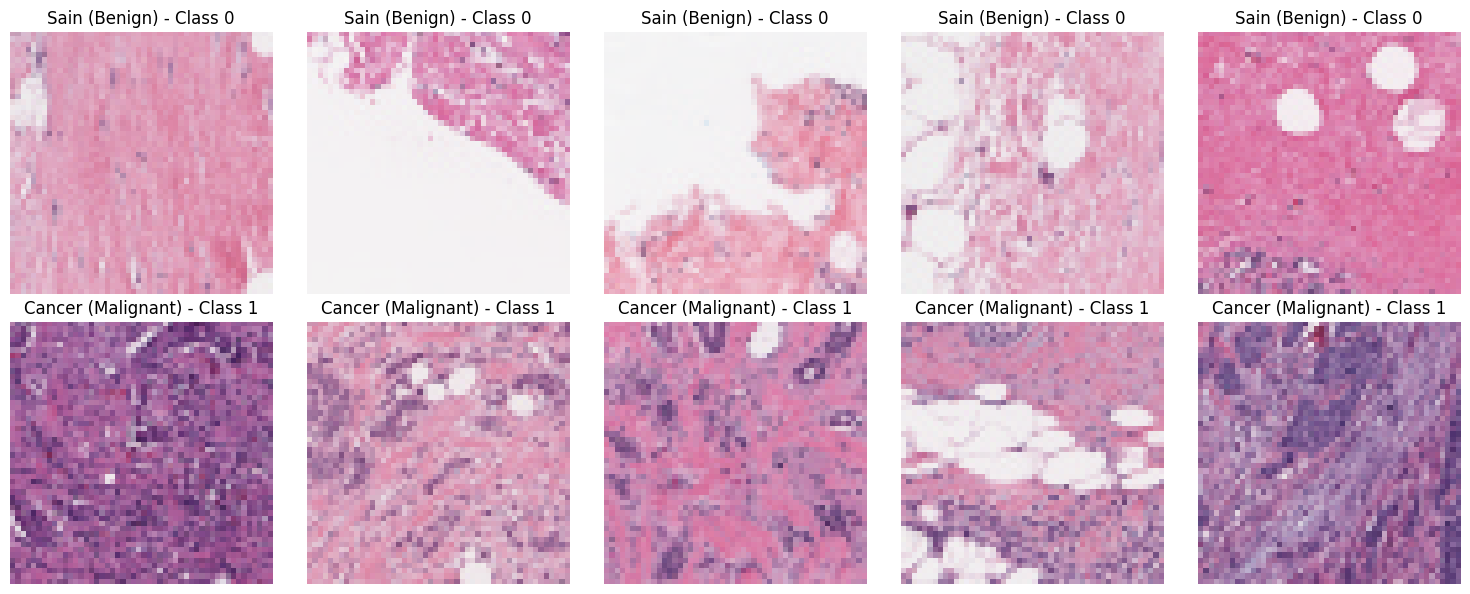

In [30]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# On configure la figure (2 lignes, 5 colonnes)
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# 1. On prend 5 images au hasard chez les SAINS (Classe 0)
healthy_samples = train_df[train_df['label'] == 0].sample(5, random_state=42)

# 2. On prend 5 images au hasard chez les MALADES (Classe 1)
cancer_samples = train_df[train_df['label'] == 1].sample(5, random_state=42)

# --- Affichage Ligne 1 : SAIN ---
for i, (index, row) in enumerate(healthy_samples.iterrows()):
    img = mpimg.imread(row['path'])
    ax = axes[0, i]
    ax.imshow(img)
    ax.set_title("Sain (Benign) - Class 0")
    ax.axis('off') # On enlève les axes moches

# --- Affichage Ligne 2 : MALADE ---
for i, (index, row) in enumerate(cancer_samples.iterrows()):
    img = mpimg.imread(row['path'])
    ax = axes[1, i]
    ax.imshow(img)
    ax.set_title("Cancer (Malignant) - Class 1")
    ax.axis('off')

plt.tight_layout()
plt.show()

# CNN

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import time
import matplotlib.pyplot as plt

# Configuration de base
BATCH_SIZE = 128
IMG_SIZE = 50
NUM_WORKERS = 2

In [33]:
# 1. Les Pipelines de transformation (Data Augmentation)
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5), # Miroir horizontal
    transforms.RandomVerticalFlip(p=0.5),   # Miroir vertical
    transforms.RandomRotation(20),          # Rotation +/- 20°
    transforms.ToTensor(),
])

val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

# 2. La Classe Dataset Custom
class BreastCancerDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = row['path']
        label = row['label']
        # Ouverture de l'image
        image = Image.open(image_path).convert('RGB')

        # Application des transfos
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)

# 3. Création des Chargeurs (DataLoaders)
train_dataset = BreastCancerDataset(train_df, transform=train_transforms)
val_dataset   = BreastCancerDataset(val_df,   transform=val_transforms)
test_dataset  = BreastCancerDataset(test_df,  transform=val_transforms)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS, # Parallélisme
    pin_memory=True          # Transfert rapide vers GPU
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)
print("✅ DataLoaders prêts !")

✅ DataLoaders prêts !


In [34]:
# Fonction utilitaire pour créer un bloc (Conv -> BN -> ReLU)
def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

# Le Réseau de Neurones complet
class BreastCancerCNN(nn.Module):
    def __init__(self):
        super(BreastCancerCNN, self).__init__()

        # Partie Convolution (Extraction de Features)
        self.block1 = conv_block(3, 32)   # 50 -> 25
        self.block2 = conv_block(32, 64)  # 25 -> 12
        self.block3 = conv_block(64, 128) # 12 -> 6

        # Partie Classification (MLP)
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
            nn.Linear(128 * 6 * 6, 512),
            nn.ReLU(),
            nn.Dropout(p=0.5), # Anti-Overfitting
            nn.Linear(512, 1)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.flatten(x)
        logits = self.classifier(x)
        return logits

print("✅ Architecture du modèle définie !")

✅ Architecture du modèle définie !


In [35]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    model = model.to(device)
    print(f"🚀 Démarrage de l'entraînement sur {device} pour {num_epochs} epochs...")

    for epoch in range(num_epochs):
        start_time = time.time()

        # --- PHASE 1 : ENTRAÎNEMENT ---
        model.train()
        running_loss, correct_preds, total_preds = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.unsqueeze(1).float()

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            predicted = (outputs > 0).float()
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = correct_preds / total_preds

        # --- PHASE 2 : VALIDATION ---
        model.eval()
        val_loss, correct_val, total_val = 0.0, 0, 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                labels = labels.unsqueeze(1).float()

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                predicted = (outputs > 0).float()
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = correct_val / total_val

        # --- STOCKAGE DES SCORES ---
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f} | "
              f"Time: {time.time() - start_time:.0f}s")

    print("🏁 Entraînement terminé !")
    return history

In [36]:
# 1. Détection du GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Calculateur : {device}")

# 2. Création du modèle
model = BreastCancerCNN().to(device)

# 3. Définition de la Loss et de l'Optimiseur
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

Calculateur : cuda


In [43]:
# On lance pour 10 époques
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=100
)

🚀 Démarrage de l'entraînement sur cuda pour 100 époques...
Epoch 1/100 | Train Loss: 0.3111 Acc: 0.8694 | Val Loss: 0.3337 Acc: 0.8610 | Time: 12s
Epoch 2/100 | Train Loss: 0.3061 Acc: 0.8698 | Val Loss: 0.3042 Acc: 0.8755 | Time: 16s
Epoch 3/100 | Train Loss: 0.3079 Acc: 0.8699 | Val Loss: 0.3137 Acc: 0.8730 | Time: 11s
Epoch 4/100 | Train Loss: 0.3063 Acc: 0.8696 | Val Loss: 0.3029 Acc: 0.8745 | Time: 11s
Epoch 5/100 | Train Loss: 0.3029 Acc: 0.8731 | Val Loss: 0.3172 Acc: 0.8740 | Time: 11s
Epoch 6/100 | Train Loss: 0.3042 Acc: 0.8714 | Val Loss: 0.3055 Acc: 0.8745 | Time: 13s
Epoch 7/100 | Train Loss: 0.3030 Acc: 0.8731 | Val Loss: 0.3397 Acc: 0.8555 | Time: 12s
Epoch 8/100 | Train Loss: 0.3004 Acc: 0.8745 | Val Loss: 0.3116 Acc: 0.8745 | Time: 11s
Epoch 9/100 | Train Loss: 0.3017 Acc: 0.8756 | Val Loss: 0.3208 Acc: 0.8755 | Time: 12s
Epoch 10/100 | Train Loss: 0.2945 Acc: 0.8751 | Val Loss: 0.3042 Acc: 0.8785 | Time: 12s
Epoch 11/100 | Train Loss: 0.2931 Acc: 0.8765 | Val Loss: 0.

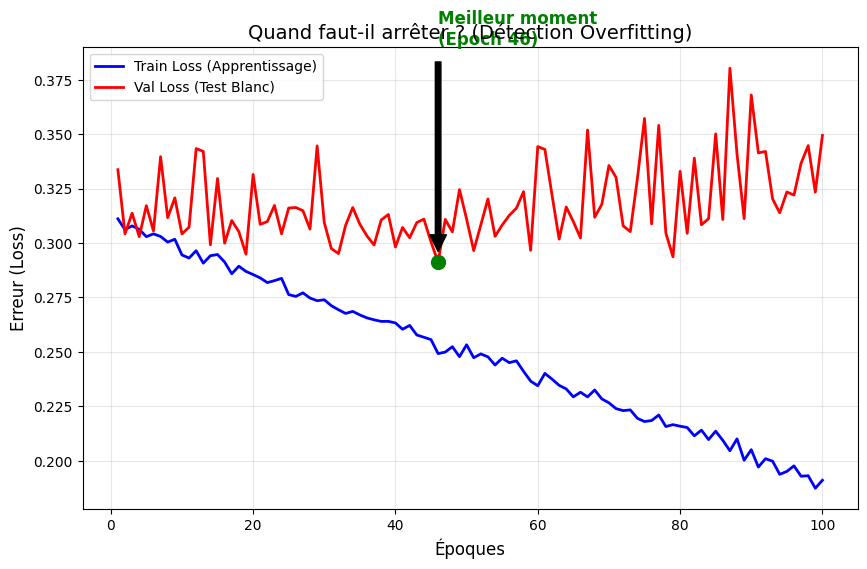

In [44]:
import matplotlib.pyplot as plt
import numpy as np

def plot_loss_curve(history):
    train_loss = history['train_loss']
    val_loss = history['val_loss']
    epochs = range(1, len(train_loss) + 1)

    # Trouver le meilleur point (Loss Validation minimale)
    best_epoch = np.argmin(val_loss) + 1
    best_val_loss = val_loss[best_epoch - 1]

    plt.figure(figsize=(10, 6))

    # 1. Tracer les courbes
    plt.plot(epochs, train_loss, 'b-', label='Train Loss (Apprentissage)', linewidth=2)
    plt.plot(epochs, val_loss, 'r-', label='Val Loss (Test Blanc)', linewidth=2)

    # 2. Marquer le point d'arrêt idéal
    plt.scatter(best_epoch, best_val_loss, c='green', s=100, zorder=5)
    plt.annotate(f'Meilleur moment\n(Epoch {best_epoch})',
                 xy=(best_epoch, best_val_loss),
                 xytext=(best_epoch, best_val_loss + 0.1),
                 arrowprops=dict(facecolor='black', shrink=0.05),
                 fontsize=12, color='green', fontweight='bold')

    plt.title('Quand faut-il arrêter ? (Détection Overfitting)', fontsize=14)
    plt.xlabel('Époques', fontsize=12)
    plt.ylabel('Erreur (Loss)', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Affiche le graph
plot_loss_curve(history)

🏥 Diagnostic du Test Set en cours...


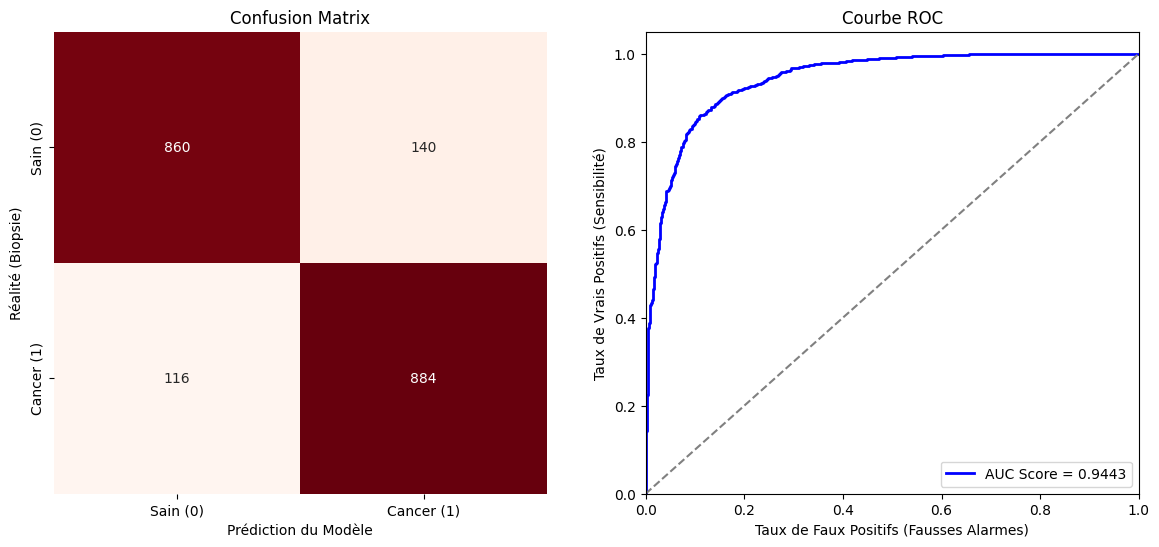

🏆 SCORE AUC FINAL : 0.9443 / 1.0
DÉTAILS CRITIQUES :
✅ Cancers correctement détectés (Vrais Positifs) : 884
✅ Sains correctement ignorés (Vrais Négatifs)   : 860
⚠️ Fausses Alarmes (Faux Positifs)              : 140
🚨 CANCERS RATÉS (Faux Négatifs - DANGER)       : 116


In [45]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch

def evaluate_model_auc(model, test_loader):
    model.eval() # On désactive le mode entraînement (pas de dropout)

    y_true = []
    y_probs = [] # On stocke les probabilités (pas juste 0 ou 1) pour l'AUC

    print("🏥 Diagnostic du Test Set en cours...")

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)

            # 1. Forward pass (Logits bruts)
            logits = model(images)

            # 2. Transformation en Probabilités (Sigmoid) -> entre 0 et 1
            probs = torch.sigmoid(logits)

            # Stockage sur CPU pour sklearn
            y_true.extend(labels.numpy())
            y_probs.extend(probs.cpu().numpy())

    # Conversion en arrays numpy
    y_true = np.array(y_true)
    y_probs = np.array(y_probs)
    # Pour la matrice de confusion, on coupe à 0.5
    y_pred = (y_probs > 0.5).astype(int)

    # --- 1. MATRICE DE CONFUSION (Le plus important) ---
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    plt.figure(figsize=(14, 6))

    # Plot A : La Matrice
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', cbar=False,
                xticklabels=['Sain (0)', 'Cancer (1)'],
                yticklabels=['Sain (0)', 'Cancer (1)'])
    plt.xlabel('Prédiction du Modèle')
    plt.ylabel('Réalité (Biopsie)')
    plt.title('Confusion Matrix')

    # --- 2. ROC CURVE & AUC ---
    # Calcul de la courbe
    fpr, tpr, thresholds = roc_curve(y_true, y_probs)
    # Calcul de l'Aire Sous la Courbe (AUC)
    roc_auc = auc(fpr, tpr)

    # Plot B : La Courbe
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC Score = {roc_auc:.4f}')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--') # La ligne du hasard
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taux de Faux Positifs (Fausses Alarmes)')
    plt.ylabel('Taux de Vrais Positifs (Sensibilité)')
    plt.title('Courbe ROC')
    plt.legend(loc="lower right")

    plt.show()

    # --- RAPPORT FINAL ---
    print("="*40)
    print(f"🏆 SCORE AUC FINAL : {roc_auc:.4f} / 1.0")
    print("="*40)
    print("DÉTAILS CRITIQUES :")
    print(f"✅ Cancers correctement détectés (Vrais Positifs) : {tp}")
    print(f"✅ Sains correctement ignorés (Vrais Négatifs)   : {tn}")
    print(f"⚠️ Fausses Alarmes (Faux Positifs)              : {fp}")
    print(f"🚨 CANCERS RATÉS (Faux Négatifs - DANGER)       : {fn}")
    print("="*40)

# Lancement
evaluate_model_auc(model, test_loader)

# BONUS : FANCY TOOLS